# Determine the Relationship between Key Press and Terminal Risk for ABSA

In [1]:
import pyspark
from pyspark.sql import SparkSession, types
from pyspark.sql.functions import col, when
import pyspark.sql.functions as F
from pyspark.sql.types import StructField, StructType
from pyspark.sql.window import Window
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import lib.pyspark_helper as helper

In [2]:
spark = SparkSession.builder.master('local[*]').appName('distribution').getOrCreate()

In [3]:
df_terminals = spark.read.csv(path='./bin/absa/terminals_absa.csv', inferSchema=True, header=True)\
    .withColumn('LastConnectDt', F.to_timestamp('LastConnectDt'))\
    .withColumn('Inserted', F.to_timestamp('Inserted'))\
    .withColumn('Updated', F.to_timestamp('Updated'))

df_terminals.printSchema()
print('rows:', df_terminals.count())

root
 |-- RecordID: integer (nullable = true)
 |-- SerialNumber: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Peripherals: string (nullable = true)
 |-- Sim1: decimal(20,0) (nullable = true)
 |-- Sim2: decimal(20,0) (nullable = true)
 |-- LastConnectDt: timestamp (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- Enterkey: integer (nullable = true)
 |-- Zerokey: integer (nullable = true)
 |-- Swipe2: integer (nullable = true)
 |-- Swipes2ok: integer (nullable = true)
 |-- Inserts: integer (nullable = true)
 |-- Printerdots: long (nullable = true)
 |-- APN1: string (nullable = true)
 |-- APN2: string (nullable = true)
 |-- Inserted: timestamp (nullable = true)
 |-- Updated: timestamp (nullable = true)

rows: 39806


## key press distributions

### enter key

In [4]:
df_terminals.select('Enterkey').sort('Enterkey', ascending=False).show(5)
helper.plot_histogram(df_terminals, 'Enterkey', log=True)

+--------+
|Enterkey|
+--------+
| 1065672|
| 1017858|
|  980793|
|  974192|
|  923616|
+--------+
only showing top 5 rows

c:\Anran\Projects\Live\AR\risk\lib\pyspark_helper.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0, y.max()])


### zero key

+-------+
|Zerokey|
+-------+
| 408748|
| 336695|
| 315927|
| 307292|
| 300452|
+-------+
only showing top 5 rows



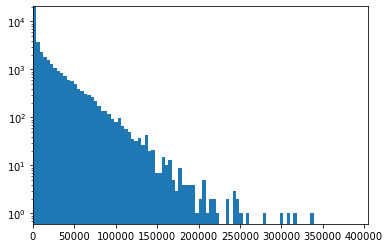

In [5]:
df_terminals.select('Zerokey').sort('Zerokey', ascending=False).show(5)
helper.plot_histogram(df_terminals, 'Zerokey', log=True)

### swipe2


+--------+
|  Swipe2|
+--------+
|20006883|
|  605906|
|  434836|
|  350541|
|  350196|
+--------+
only showing top 5 rows



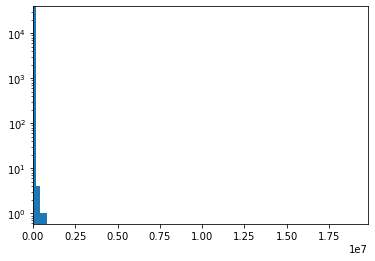

In [6]:
df_terminals.select('Swipe2').sort('Swipe2', ascending=False).show(5)
helper.plot_histogram(df_terminals, 'Swipe2', binStep=100, log=True)

### swipes2ok

+---------+
|Swipes2ok|
+---------+
|    74755|
|    52784|
|    34856|
|    21594|
|    21065|
+---------+
only showing top 5 rows



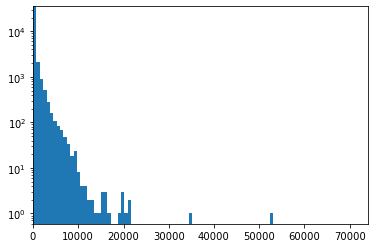

In [7]:
df_terminals.select('Swipes2ok').sort('Swipes2ok', ascending=False).show(5)
helper.plot_histogram(df_terminals, 'Swipes2ok', log=True)

### inserts

+-------+
|Inserts|
+-------+
| 336695|
| 300452|
| 208432|
| 138253|
| 118250|
+-------+
only showing top 5 rows



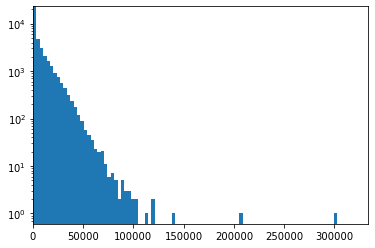

In [8]:
df_terminals.select('Inserts').sort('Inserts', ascending=False).show(5)
helper.plot_histogram(df_terminals, 'Inserts', log=True)

### printer dots

+-----------+
|Printerdots|
+-----------+
| 4293936424|
| 4291295220|
| 4291219380|
| 4289731798|
| 4287997223|
+-----------+
only showing top 5 rows



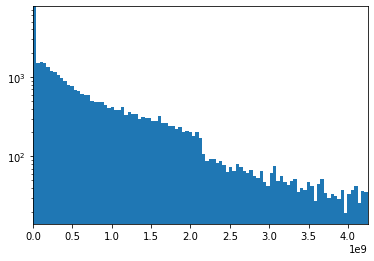

In [9]:
df_terminals.select('Printerdots').sort('Printerdots', ascending=False).show(5)
helper.plot_histogram(df_terminals, 'Printerdots', log=True)

## key risk profile

In [10]:
keys = ['Enterkey', 'Zerokey', 'Swipe2', 'Swipes2ok', 'Inserts', 'Printerdots']

for key in keys:
    window_spec = Window.orderBy(key)

    df_terminals = df_terminals.withColumn(
        '{}_percentile'.format(key), 
        F.percent_rank().over(window_spec) * 100
    )

df_terminals = df_terminals.withColumn('overall_percentile', helper.get_avg_risk(keys))
df_terminals = df_terminals.withColumn('overall_risk', helper.get_risk_interval('overall_percentile'))

df_terminals.printSchema()
df_terminals.show(5, vertical=True)

root
 |-- RecordID: integer (nullable = true)
 |-- SerialNumber: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Peripherals: string (nullable = true)
 |-- Sim1: decimal(20,0) (nullable = true)
 |-- Sim2: decimal(20,0) (nullable = true)
 |-- LastConnectDt: timestamp (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- Enterkey: integer (nullable = true)
 |-- Zerokey: integer (nullable = true)
 |-- Swipe2: integer (nullable = true)
 |-- Swipes2ok: integer (nullable = true)
 |-- Inserts: integer (nullable = true)
 |-- Printerdots: long (nullable = true)
 |-- APN1: string (nullable = true)
 |-- APN2: string (nullable = true)
 |-- Inserted: timestamp (nullable = true)
 |-- Updated: timestamp (nullable = true)
 |-- Enterkey_percentile: double (nullable = true)
 |-- Zerokey_percentile: double (nullable = true)
 |-- Swipe2_percentile: double (nullable = true)
 |-- Swipes2ok_percentile: double (nullable = true)
 |-- Inserts_percentile: double (nullable = true)
 |-- 

+------------+-----+
|overall_risk|count|
+------------+-----+
|  1_very_low| 6956|
|       2_low| 7780|
|    3_medium|10018|
|      4_high|10375|
| 5_very_high| 4677|
+------------+-----+



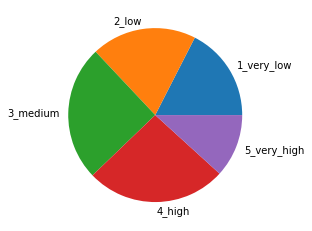

In [11]:
df_terminals_group_risk = df_terminals.groupBy('overall_risk').count().sort('overall_risk')
df_terminals_group_risk.show()

helper.plot_pie(df_terminals_group_risk, 'count', 'overall_risk')

## correlate key press with risk

In [12]:
#* read inventory
schema_inventory = StructType([
    StructField('serial_number', types.StringType(), nullable=False),
    StructField('item_type', types.StringType(), nullable=False),
    StructField('status', types.StringType(), nullable=False),
    StructField('date_inserted', types.TimestampType(), nullable=False),
    StructField('bank', types.StringType(), nullable=False)
])

df_inventory = spark.read.csv(path='./out/inventory_all.csv', schema=schema_inventory, header=True)
df_inventory = df_inventory.withColumn('serial_number', F.substring('serial_number', -15, 15))

df_inventory.printSchema()
df_inventory.show(5)
print('total rows:', df_inventory.count())

root
 |-- serial_number: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- status: string (nullable = true)
 |-- date_inserted: timestamp (nullable = true)
 |-- bank: string (nullable = true)

+---------------+--------------------+---------+--------------------+----+
|  serial_number|           item_type|   status|       date_inserted|bank|
+---------------+--------------------+---------+--------------------+----+
|   N77801693050|N910 (N7U-G77KXE0...|  Shipped|2021-05-21 10:44:...| fnb|
|131167213092227|        TWE31311672R|  Shipped|2021-05-05 09:36:...|sbsa|
|131167213092253|        TWE31311672R|  Shipped|2021-05-05 09:36:...|sbsa|
|131167213092167|        TWE31311672R|  Shipped|2021-05-05 09:36:...|sbsa|
|131167213131995|        TWE31311672R|Activated|2021-05-05 09:36:...|sbsa|
+---------------+--------------------+---------+--------------------+----+
only showing top 5 rows

total rows: 394833


In [13]:
df_joined = df_inventory.join(
    df_terminals,
    (df_inventory.serial_number == df_terminals.SerialNumber),
    'inner'
).select('serial_number', 'overall_percentile', 'overall_risk', 'status', 'bank')
df_joined.printSchema()
print('joined rows:', df_joined.count())

root
 |-- serial_number: string (nullable = true)
 |-- overall_percentile: double (nullable = true)
 |-- overall_risk: string (nullable = true)
 |-- status: string (nullable = true)
 |-- bank: string (nullable = true)

joined rows: 39805


total written off machine: 280
+------------+-----+
|overall_risk|count|
+------------+-----+
|  1_very_low|    2|
|       2_low|   13|
|    3_medium|   41|
|      4_high|  105|
| 5_very_high|  119|
+------------+-----+



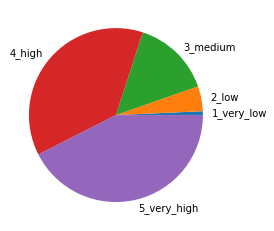

In [14]:
#* written off terminal grouped by risk
df_joined_group_risk = df_joined.filter(
    (col('status') == 'Written Off') | 
    (col('status') == 'Awaiting Write-Off')
).groupBy('overall_risk').count().sort('overall_risk')

print('total written off machine:', df_joined_group_risk.agg(F.sum("count")).collect()[0][0])
df_joined_group_risk.show()
helper.plot_pie(df_joined_group_risk, 'count', 'overall_risk')

___
### reminder: to save dataframe to csv

`df_joined.toPandas().to_csv('out/age_absa.csv', index=False)`